In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv('~/Documents/research/tansey/msk_intern/pyro_model/data/rep-gdsc-ctd2.csv')
df.head()

,Drug.Name,ccle,REP_upper_asymptote,REP_lower_asymptote,REP_ec50,REP_slope,REP_min_dose,REP_max_dose,REP_published_auc,CTD2_upper_asymptote,...,GDSC_slope,GDSC_max_dose,GDSC_min_dose,GDSC_published_auc,min_dose,max_dose,moa,REP_auc_overlap,CTD2_auc_overlap,GDSC_auc_overlap
0,MASITINIB,MFE296,1,2.196474,0.070624,-0.194326,0.00061,10,1.592769,1.00044,...,4.480547,20.0,0.078125,0.94,0.078125,10.0,"KIT inhibitor, PDGFR tyrosine kinase receptor ...",1.0,0.972505,0.998475
1,MASITINIB,PSN1,1,2.173738,0.262286,-0.335760,0.00061,10,1.684585,1.00000,...,11.795266,20.0,0.078125,0.88,0.078125,10.0,"KIT inhibitor, PDGFR tyrosine kinase receptor ...",1.0,0.999926,0.999475
2,MASITINIB,KYSE150,1,1.758293,0.156294,-0.256370,0.00061,10,1.409029,1.00010,...,0.219758,20.0,0.078125,0.98,0.078125,10.0,"KIT inhibitor, PDGFR tyrosine kinase receptor ...",1.0,0.999783,0.987924
3,MASITINIB,ESS1,1,1.981073,0.481603,0.095135,0.00061,10,1.448933,0.99960,...,2.418659,20.0,0.078125,0.86,0.078125,10.0,"KIT inhibitor, PDGFR tyrosine kinase receptor ...",1.0,0.993567,0.963070
4,MASITINIB,A172,1,2.583880,0.026078,-0.192746,0.00061,10,1.714048,0.99960,...,10.708394,20.0,0.078125,0.88,0.078125,10.0,"KIT inhibitor, PDGFR tyrosine kinase receptor ...",1.0,0.999033,0.999867


In [3]:
columns = ['Drug.Name', 'ccle', 'REP_auc_overlap', 'CTD2_auc_overlap', 'GDSC_auc_overlap']
df = df[columns]
df.head()

,Drug.Name,ccle,REP_auc_overlap,CTD2_auc_overlap,GDSC_auc_overlap
0,MASITINIB,MFE296,1.0,0.972505,0.998475
1,MASITINIB,PSN1,1.0,0.999926,0.999475
2,MASITINIB,KYSE150,1.0,0.999783,0.987924
3,MASITINIB,ESS1,1.0,0.993567,0.963070
4,MASITINIB,A172,1.0,0.999033,0.999867


In [4]:
drugs = df['Drug.Name'].unique()
samples = df['ccle'].unique()
sparsity = len(df) / (len(drugs) * len(samples))
print('num drugs: ' + str(len(drugs)))
print('num samples: ' + str(len(samples)))
print('num datapoints: ' + str(len(df)))

num drugs: 84
num samples: 318
num datapoints: 25670


In [5]:
def list_to_indices(keys):
    n_keys = len(keys)
    values = range(n_keys)
    return dict(zip(keys, values))

In [6]:
# create drug, sample indices
drug_indices = list_to_indices(drugs)
sample_indices = list_to_indices(samples)
# map drugs, samples to indices
df['drug_id'] = df['Drug.Name'].replace(drug_indices)
df['sample_id'] = df['ccle'].replace(sample_indices)
df.head()
# create matrix for each dataset

,Drug.Name,ccle,REP_auc_overlap,CTD2_auc_overlap,GDSC_auc_overlap,drug_id,sample_id
0,MASITINIB,MFE296,1.0,0.972505,0.998475,0,0
1,MASITINIB,PSN1,1.0,0.999926,0.999475,0,1
2,MASITINIB,KYSE150,1.0,0.999783,0.987924,0,2
3,MASITINIB,ESS1,1.0,0.993567,0.963070,0,3
4,MASITINIB,A172,1.0,0.999033,0.999867,0,4


In [7]:
def average_values(df, cols, val_name):
    d = df.groupby(cols)[val_name].mean().reset_index(name='mean_auc_overlap')
    assert len(d) == len(df[cols].drop_duplicates())
    return d

def create_matrix(df, n_rows, n_cols, row_name, col_name, val_name):
    avg_df = average_values(df, [row_name, col_name], val_name)
    arr = np.zeros((n_rows, n_cols))
    row = avg_df[row_name].to_numpy()
    col = avg_df[col_name].to_numpy()
    val = avg_df['mean_auc_overlap'].to_numpy()
    arr[row, col] = val
    return arr

In [8]:
n_samples = len(samples)
n_drugs = len(drugs)
rep_arr = create_matrix(df, n_samples, n_drugs, 'sample_id', 'drug_id', 'REP_auc_overlap')
gdsc_arr = create_matrix(df, n_samples, n_drugs, 'sample_id', 'drug_id', 'GDSC_auc_overlap')
ctd2_arr = create_matrix(df, n_samples, n_drugs, 'sample_id', 'drug_id', 'CTD2_auc_overlap')

In [9]:
print('nnz REP: ' + str(np.count_nonzero(rep_arr)))
print('nnz GDSC: ' + str(np.count_nonzero(gdsc_arr)))
print('nnz CTD2: ' + str(np.count_nonzero(ctd2_arr)))

nnz REP: 16650
nnz GDSC: 16650
nnz CTD2: 16650


In [10]:
# need to check whether you have multiple readings for the same sample + drug!!
df.groupby(['drug_id', 'sample_id']).count().describe([.05, .1, .2, .8, .9, .95])

,Drug.Name,ccle,REP_auc_overlap,CTD2_auc_overlap,GDSC_auc_overlap
count,16650.000000,16650.000000,16650.000000,16650.000000,16650.000000
mean,1.541742,1.541742,1.541742,1.541742,1.541742
std,1.770574,1.770574,1.770574,1.770574,1.770574
min,1.000000,1.000000,1.000000,1.000000,1.000000
5%,1.000000,1.000000,1.000000,1.000000,1.000000
10%,1.000000,1.000000,1.000000,1.000000,1.000000
20%,1.000000,1.000000,1.000000,1.000000,1.000000
50%,1.000000,1.000000,1.000000,1.000000,1.000000
80%,1.000000,1.000000,1.000000,1.000000,1.000000
90%,4.000000,4.000000,4.000000,4.000000,4.000000


In [13]:
d = df.groupby(['drug_id', 'sample_id']).count()
d.head()

Drug.Name  ccle  REP_auc_overlap  CTD2_auc_overlap   
drug_id sample_id                                                       
0       0                  1     1                1                 1  \
        1                  1     1                1                 1   
        2                  1     1                1                 1   
        3                  1     1                1                 1   
        4                  1     1                1                 1   

                   GDSC_auc_overlap  
drug_id sample_id                    
0       0                         1  
        1                         1  
        2                         1  
        3                         1  
        4                         1

In [11]:
n_obs_cells = 16650
n_total_cells = n_drugs * n_samples
sparsity = n_obs_cells / n_total_cells
print('matrix dimensions: ' + str(n_samples) + ' x ' + str(n_drugs) + ' = ' + str(n_total_cells))
print('num cells w/ observations: ' + str(n_obs_cells))
print('sparsity: ' + str(n_obs_cells) + ' / ' + str(n_total_cells) + ' = ' + str(sparsity))

matrix dimensions: 318 x 84 = 26712
num cells w/ observations: 16650
sparsity: 16650 / 26712 = 0.6233153638814016


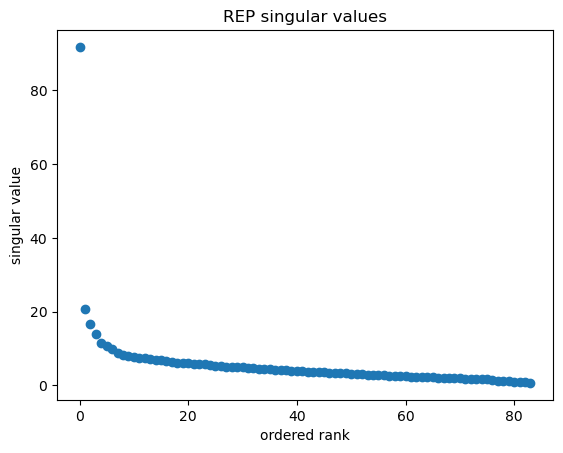

In [12]:
import matplotlib.pyplot as plt
# rep matrix
U, S, Vh = np.linalg.svd(rep_arr)
plt.ylabel('singular value')
plt.xlabel('ordered rank')
plt.title('REP singular values')
plt.scatter(range(len(S)), S)

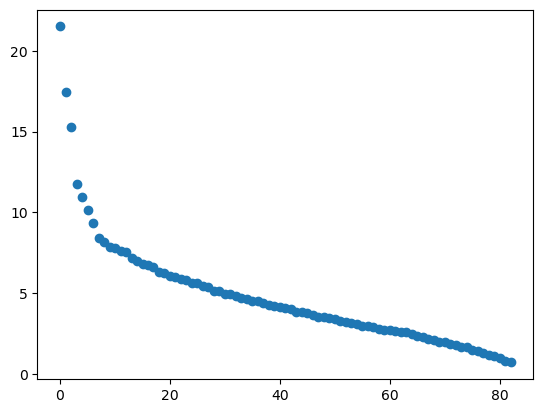

In [25]:
plt.scatter(range(len(S[1:])), S[1:])

In [ ]:
print(S)

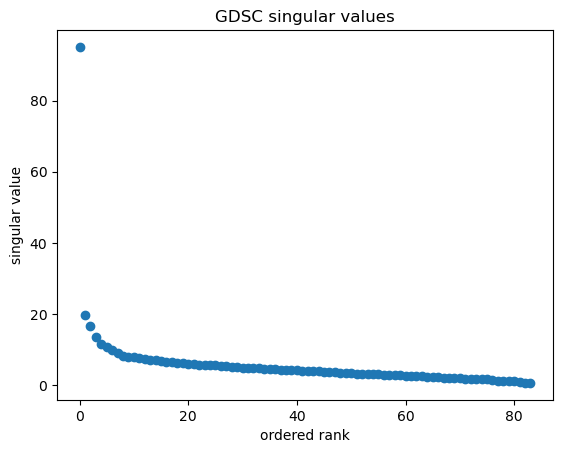

In [13]:
# gdsc matrix
U, S, Vh = np.linalg.svd(gdsc_arr)
plt.ylabel('singular value')
plt.xlabel('ordered rank')
plt.title('GDSC singular values')
plt.scatter(range(len(S)), S)

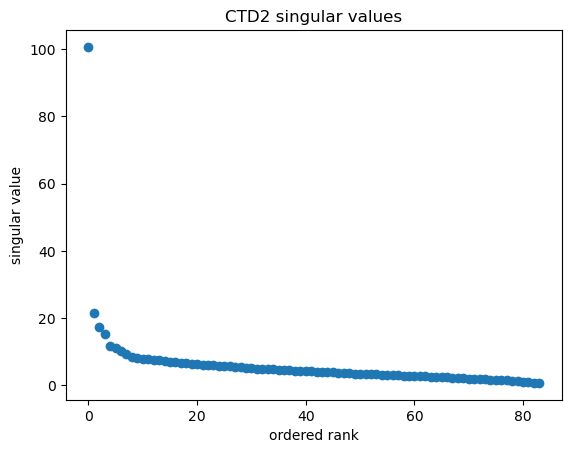

In [14]:
# ctd2 matrix
U, S, Vh = np.linalg.svd(ctd2_arr)
plt.ylabel('singular value')
plt.xlabel('ordered rank')
plt.title('CTD2 singular values')
plt.scatter(range(len(S)), S)

In [15]:
def pearson_correlation(vec1, vec2):
    pearson_corr = np.corrcoef(vec1, vec2)
    return pearson_corr[0, 1]

In [16]:
# compute correlation between all 3 datasets
rep_val = df['REP_auc_overlap'].to_numpy()
gdsc_val = df['GDSC_auc_overlap'].to_numpy()
ctd2_val = df['CTD2_auc_overlap'].to_numpy()
# rep vs gdsc correlation
print('pearson correlation (r)...')
print('REP vs GDSC: ' + str(pearson_correlation(rep_val, gdsc_val)))
# rep vs ctd2 correlation
print('REP vs CTD2: ' + str(pearson_correlation(rep_val, ctd2_val)))
# gdsc vs ctd2 correlation
print('GDSC vs CTD2: ' + str(pearson_correlation(gdsc_val, ctd2_val)))

pearson correlation (r)...
REP vs GDSC: 0.5817166012180188
REP vs CTD2: 0.5645457390093442
GDSC vs CTD2: 0.604617984322504


In [17]:
def get_unique_pairs(df, col1, col2):
    a = df[[col1, col2]].drop_duplicates()
    pairs = list(zip(a[col1], a[col2]))
    assert len(pairs) == len(set(pairs))
    return pairs

def get_train_test_indices(pairs, n_train):
    n_pairs = len(pairs)
    idx = np.random.permutation(n_pairs)
    train_idx = idx[:n_train]
    test_idx = idx[n_train:]
    assert set(train_idx).isdisjoint(set(test_idx))
    return train_idx, test_idx

def index_pairs(pairs, indices):
    p = np.array(pairs)
    idx = np.array(indices)
    return list(map(tuple, p[idx]))

def split_by_pairs(df, col1, col2, train_pairs, test_pairs):
    df['pair'] = list(zip(df[col1], df[col2]))
    train_df = df.loc[df['pair'].isin(train_pairs)]
    test_df = df.loc[df['pair'].isin(test_pairs)]
    assert set(train_df['pair']).isdisjoint(set(test_df['pair']))
    return train_df, test_df

def split_train_test(df, n_train):
    col1 = 'sample_id'
    col2 = 'drug_id'
    # get unique sample-drug pairs
    pairs = get_unique_pairs(df, col1, col2)
    train_idx, test_idx = get_train_test_indices(pairs, n_train)
    train_pairs = index_pairs(pairs, train_idx)
    test_pairs = index_pairs(pairs, test_idx)
    return split_by_pairs(df, col1, col2, train_pairs, test_pairs)

def low_rank(M, r):
    U, S, Vh = np.linalg.svd(M, full_matrices=True)
    return np.dot(U[:, :r] * S[:r], Vh[:r,:])

def get_singular_values(M):
    U, S, Vh = np.linalg.svd(M, full_matrices=True)
    return S


In [18]:
n_train = int(np.ceil(n_obs_cells * 0.9))
train_df, test_df = split_train_test(df, n_train)

In [19]:
# create matrix from train_df
n_rows = n_samples
n_cols = n_drugs
row_name = 'sample_id'
col_name = 'drug_id'
val_name = 'REP_auc_overlap'
gt_arr = create_matrix(df, n_rows, n_cols, row_name, col_name, val_name)
train_arr = create_matrix(train_df, n_rows, n_cols, row_name, col_name, val_name)
# get low-rank approximation of matrix
rank = 2
low_rank_train_arr = low_rank(train_arr, rank)
# compute correlation for train vals and test vals
# get train-sample-idx
row_idx = train_df['sample_id']
col_idx = train_df['drug_id']
actual = gt_arr[row_idx, col_idx]
predicted = low_rank_train_arr[row_idx, col_idx]
train_corr = pearson_correlation(actual, predicted)
print('train_corr: ' + str(train_corr))
# get train-drug-idx
# get train-actual vector
# get train-predicted vector
# get pearson corr
# repeat for test
row_idx = test_df['sample_id']
col_idx = test_df['drug_id']
actual = gt_arr[row_idx, col_idx]
predicted = low_rank_train_arr[row_idx, col_idx]
test_corr = pearson_correlation(actual, predicted)
print('test_corr: ' + str(test_corr))

train_corr: 0.6500826342989203
test_corr: 0.609925108618818


In [20]:
s = get_singular_values(low_rank_train_arr)
print(s)

[8.29281881e+01 1.86766418e+01 2.11677993e-14 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.17697869e-15 8.17697869e-15 8.17697869e-15
 8.17697869e-15 8.176978

In [21]:
a = np.random.randn(9, 6)
low_a = low_rank(a, 4)
s = get_singular_values(low_a)
print(s)

[4.79721078e+00 3.81498398e+00 3.28327349e+00 2.70327305e+00
 5.70606636e-16 1.44375424e-16]


In [ ]:
np.dot(U[:, :5] * S[:5], Vh[:5,:])

In [ ]:
print(a)

In [ ]:
col1 = 'sample_id'
col2 = 'drug_id'
# get unique sample-drug pairs
pairs = get_unique_pairs(df, col1, col2)
train_idx, test_idx = get_train_test_indices(pairs, n_train)
print(train_idx)
print(test_idx)
train_pairs = pairs[train_idx]
test_pairs = pairs[test_idx]
return split_by_pairs(df, col1, col2, train_pairs, test_pairs)

In [ ]:
# ctd2 matrix
a = np.random.randn(n_samples, n_drugs)
U, S, Vh = np.linalg.svd(a)
plt.ylabel('singular value')
plt.xlabel('ordered rank')
plt.title('singular values of random matrix')
plt.scatter(range(len(S)), S)

In [ ]:
# get pairs
# choose a random 10%: shuffle, then take first 10%
# split df into train and test

train_df, test_df = split_train_test(df, n_train)
# create (avg) matrix from train set


In [ ]:
# add in random seeds!
# for training model, use normal df (not avg df) to split, train, test, etc

In [ ]:
# X convert matrix to matrix of means
# split indices into train / test (random holdout)
# write function to get low rank approximation
# write low rank baseline: split data, get low rank approximation, plot over diff values of k

In [ ]:
# write function to generate low-rank matrix and test
# split indices into train / test
# do low-rank approximation and compare correlation on train vs test

In [ ]:
# If all matrices are low rank, can you:
# hold out test data
# compute low-rank factorization of each matrix
# Do matrix division / find the pseudo inverse to compute U.
# How well does U perform?
# Is the question here about finding a mapping between two different experiments, or transfer learning in a setting
# where the second experiment has only a small amount of data? Because I don't feel like this would help the small
# data problem...

In [ ]:
# plot distribution of AUC values
# for each (sample, drug) pair with multiple values, find variance --> plot variance of these values
# need to average together the readings for different (sample, drug) pairs!

In [ ]:
# how to deal with missing data???

In [ ]:
# run model w/ randomly held-out data (~10%) and compare train vs test
# can also do this with low-rank approx!
# And also...
# Start notebook!
# And also...
# Look at sparsity of matrix (to see whether missing entries are evenly distributed or not)
# Split matrix into cross-validation folds to do k-fold cross-val (could use block method described by Wes)
# And also...
# Look at matrices in matlab (with missing data colored differently)...cluster bands in rows and columns
# Do a low-rank approximation and try to predict on held-out data
# How to do low-rank approximation on matrix with missing data?
# What to plot as a sanity check? Correlation between the different datasets? (Concordance?) 
# Pearson vs spearman corr? Look up these, + concordance!
# How are the original authors measuring concordance, and can I reproduce these results?
# ** Why are there so many pure 1s in the dataset???